In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from DSOhelper import addsubfiglabels,get_oscilloscope_data,getvoltage,plot_scope_data,subplot_scope_data

In [2]:
from scipy.signal import find_peaks

## determine the mean height of peaks vs overvoltage

In [59]:
datafolder = "vary_led_1562/"
files = sorted([f for f in os.listdir(datafolder) if f[:4]=="temp"])
file=files[0]
len(files),files[::len(files)-1]

(10000, ['temp0000000.CSV', 'temp0009999.CSV'])

In [60]:
dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")

In [61]:
headers

{1: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH1',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 10.0,
  'Vertical Scale': 0.5,
  'Vertical Position': -1.78,
  'Horizontal Units': 'S',
  'Horizontal Scale': 2e-05,
  'Horizontal Position': -3.2e-06,
  'Horizontal Mode': 'Main',
  'SincET Mode': 'Real Time',
  'Sampling Period': 2e-08,
  'Horizontal Old Scale': 2e-05,
  'Horizontal Old Position': -3.2e-06,
  'Firmware': 'V1.23',
  'Mode': 'Fast'},
 2: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH2',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 1.0,
  'Vertical Scale': 0.2,
  'Vertical Position': -2.24,
  'Horizontal Units': 'S',
  'Horizontal Scale'

In [62]:
headers[1]["Sampling Period"],headers[1]["Vertical Scale"]

(2e-08, 0.5)

### plotting a subset of data for sanity check

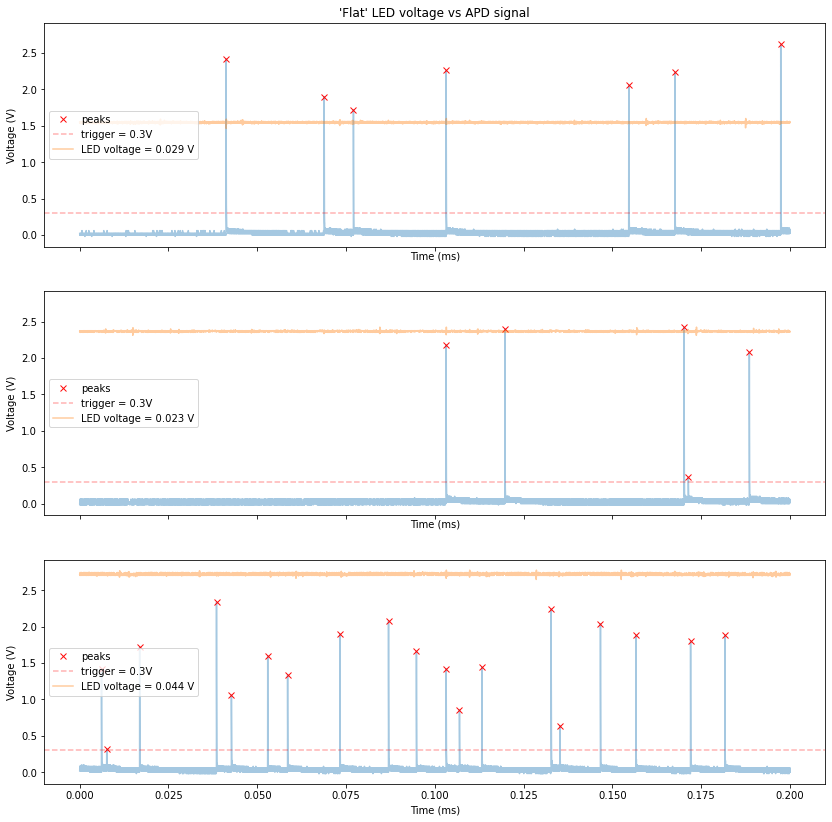

In [119]:
zeroOverVoltage = 139.3
CH=1
fig,axx = plt.subplots(3,1,figsize=(14,14),sharey=True,sharex=True)
for i,file,ax in zip(range(len(axx)),['temp0000205.CSV','temp0005505.CSV','temp0009505.CSV'],axx):
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    xscale=1e3
    subplot_scope_data(dataseq,headers,ax,alpha=0.4,xscale=xscale) 
    peak_x , peak_heights = find_peaks(dataseq[CH],height=15)
    ax.plot(peak_x*headers[CH]["Sampling Period"]*xscale,getvoltage(peak_heights["peak_heights"],headers[CH]),"x",c="r",alpha=0.96,label="peaks")
    ax.axhline(headers[CH]["Trigger Level"],c="r",ls="--",alpha=0.3,label=f"trigger = {headers[CH]['Trigger Level']}V")
    subplot_scope_data(dataseq,headers,ax,CH=2,alpha=0.4,xscale=xscale,label=f"LED voltage = {np.mean(getvoltage(dataseq[CH] ,headers[CH])):.3f} V")
    ax.legend(loc="center left")
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Time (ms)")
    if i ==0:
        ax.set_title("'Flat' LED voltage vs APD signal")
plt.savefig("results08_01_flatLEDvoltage.png")

In [96]:
%%time
average_led_voltage=[]
average_peak_counts = []
for file in files[::]:
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    average_led_voltage.append(np.mean(getvoltage(dataseq[2],headers[2])))
    peak_x , peak_heights = find_peaks(dataseq[1],height=15)
    average_peak_counts.append(len(peak_x))

Wall time: 2min 29s


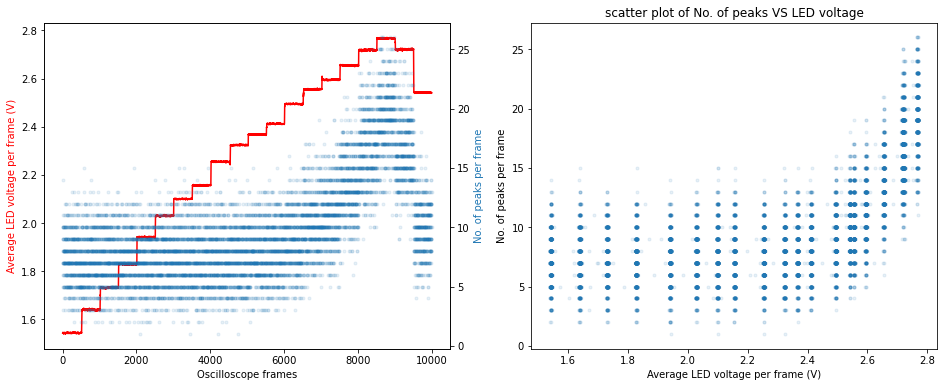

In [123]:
fig,axx = plt.subplots(1,2,figsize=(16,6))
ax=axx[0]
ax.plot(average_led_voltage,color="red")
##ax.set_title("LED voltage")
ax.set_ylabel("Average LED voltage per frame (V)",color="red")
ax.set_xlabel("Oscilloscope frames")
ax=axx[0].twinx()
ax.plot(average_peak_counts,".",alpha=0.1)
#ax.set_title("counts per frame")
ax.set_ylabel("No. of peaks per frame",color="tab:blue")

ax=axx[1]
ax.scatter(average_led_voltage,average_peak_counts,marker=".",alpha=0.1)
ax.set_xlabel("Average LED voltage per frame (V)")
ax.set_ylabel("No. of peaks per frame")
ax.set_title("scatter plot of No. of peaks VS LED voltage")
plt.savefig("results08_02_overviewplot_with_transients.png")

## G2 plot, are photons from led coherent?

In [124]:
from scipy import signal

In [152]:
voltages = getvoltage(dataseq[1],headers[1])
corrsame = signal.correlate(voltages,voltages, mode='same')

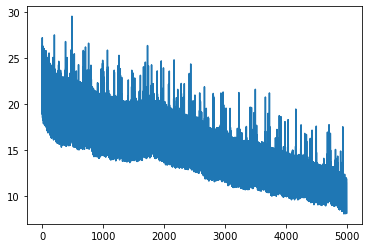

In [167]:
plt.plot(corrsame[5010:])

In [ ]:
https://web.archive.org/web/20121023140645/http://www.stanford.edu/group/yamamotogroup/Thesis/DFthesis.pdf

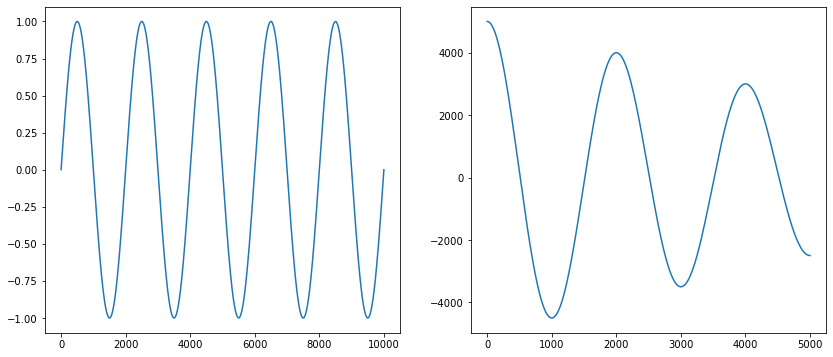

In [182]:
voltages = np.sin(5*np.linspace(0,2*np.pi,10000))
fig,axx=plt.subplots(1,2,figsize=(14,6))
axx[0].plot(voltages)
corrsame = signal.correlate(voltages,voltages, mode='same')
axx[1].plot(corrsame[5000:])

In [134]:
from scipy import signal
from numpy.random import default_rng
rng = default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x])
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]

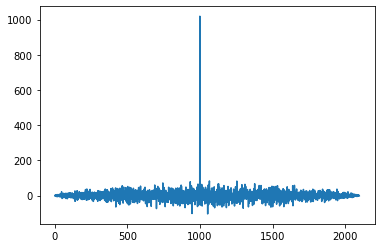

In [135]:
plt.plot(correlation)

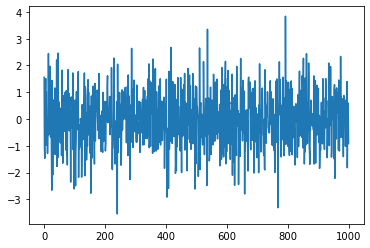

In [137]:
plt.plot(x)

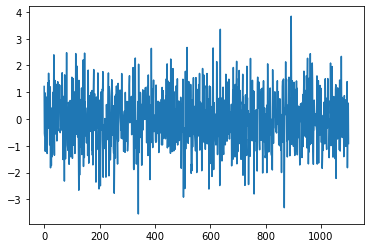

In [138]:
plt.plot(y)

In [140]:
lag

-100

In [141]:
lags

array([-1099, -1098, -1097, ...,   997,   998,   999])